In [332]:
import self_distillation
import saving_loading
import generate
import wandb

import util
import os
import torch

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"


In [333]:
import random
steps = 2
# prompts = [992,2,  625, 614] # mushroom, shark, gekko (25), tuktuk, kimono
# prompts = [538, 576, 616, 649, 719] #church, venice, rope, stonehenge, piggybank
# prompts = [538, 616, 649, 719] #church, rope, stonehenge, piggybank

prompts = [random.randrange(0, 1000, 1) for i in range(2)]
BASE = r"D:\BACKUP\CURRENT DIFFUSION THESIS"
vertical = False



if vertical:
    shape = (len(prompts), 1)
else:
    shape = (1, len(prompts))
# shape = [1, 4]

In [2]:
import numpy as np
gradient_updates = 4000

In [52]:
(1 / np.append(step_sizes[1:],1))[::-1]

array([1.        , 0.5       , 0.25      , 0.16666667, 0.125     ,
       0.1       , 0.08333333, 0.07142857, 0.0625    , 0.05555556,
       0.05      , 0.04545455, 0.04166667, 0.03846154, 0.03571429,
       0.03333333, 0.03125   , 0.02941176, 0.02777778, 0.02631579,
       0.025     , 0.02380952, 0.02272727, 0.02173913, 0.02083333,
       0.02      , 0.01923077, 0.01851852, 0.01785714, 0.01724138,
       0.01666667, 0.01612903])

In [54]:
step_sizes = np.arange(64, 0, -2)
update_list = np.exp((1 / np.append(step_sizes[1:],1))[::-1]) / np.sum(np.exp((1 / np.append(step_sizes[1:],1))[::-1]))
update_list = (update_list * gradient_updates /  np.append(step_sizes[1:],1)).astype(int) * 2

print(update_list)

[  8   6   4   4   4   4   4   4   4   4   4   4   6   6   6   6   6   8
   8   8  10  10  12  14  16  18  22  28  36  56 112 226]


In [37]:
step_sizes = np.arange(64, 0, -2)
update_list = np.exp(1 / np.append(step_sizes[1:],1)) / np.sum(np.exp(1 / np.append(step_sizes[1:],1)))
update_list = ( update_list* gradient_updates /  np.append(step_sizes[1:],1)).astype(int) * 2

print(update_list)

[  2   2   2   4   4   4   4   4   4   4   4   4   6   6   6   6   6   8
   8   8  10  10  12  14  16  20  24  30  42  70 182 604]


In [23]:
import math
steps = 64


halvings = math.floor(math.log(64)/math.log(2))
updates_per_halving = int(gradient_updates / halvings)
step_sizes = []
for i in range(halvings):
    step_sizes.append(int((steps) / (2**i)))
update_list = []
for i in step_sizes:
    update_list.append(int(updates_per_halving / int(i/ 2)))

In [38]:
update_list = np.array(update_list)
step_sizes = np.array(step_sizes)

In [39]:
np.sum(update_list * step_sizes)

8692

# CIN:

In [334]:
config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_path=f"{cwd}/models/cin256_original.ckpt"
dsdi = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_4000\\iterative\cin_DSDI_64_1e-07_4000\\2.pt"
dsdgl = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_4000\gradual_linear\cin_DSDGL_64_1e-07_4000\\1.pt"
dsdn = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_4000\\naive\cin_DSDN_64_1e-07_4000\\32.pt"
dsdgexp = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_4000\gradual_exp\cin_DSDGEXP_64_1e-07_4000\\1.pt"
tsd = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_previous\TSD\TSD_cin_50k_1e8\\16.pt"



## All versions

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


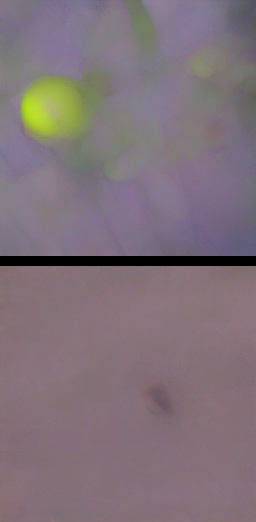

In [335]:
teacher, sampler_student = util.create_models(config_path, original_path, student=False)
new_image, noise_list, prompt_list = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="original", prompts=prompts)
del teacher, sampler_student
torch.cuda.empty_cache()
original_img = new_image
new_image

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


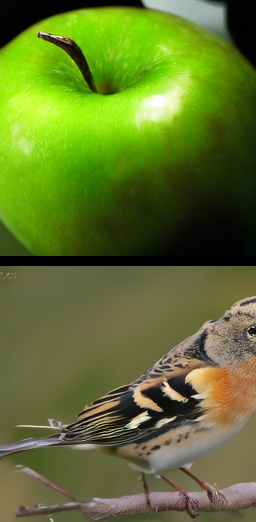

In [336]:
teacher, sampler_student = util.create_models(config_path, original_path, student=False)
new_image, noise_list, prompt_list = generate.ablation(sampler_student, steps=64, shape=shape, noise_list = noise_list, celeb=False, model_type="original", prompt_list=prompts)
del teacher, sampler_student
torch.cuda.empty_cache()
original_64_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


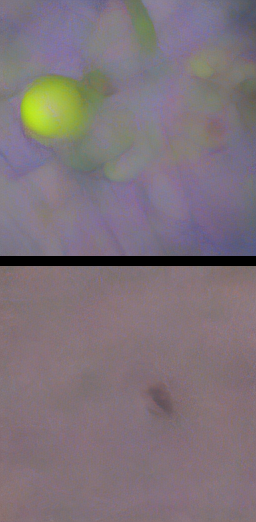

In [337]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdgexp, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="DSDGEXP", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdgexp_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


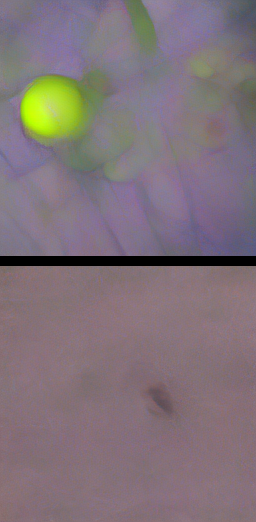

In [338]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdi, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="DSDI", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdi_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


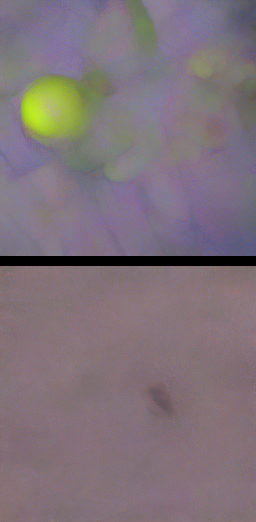

In [339]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdgl, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="DSDGL", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdgl_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


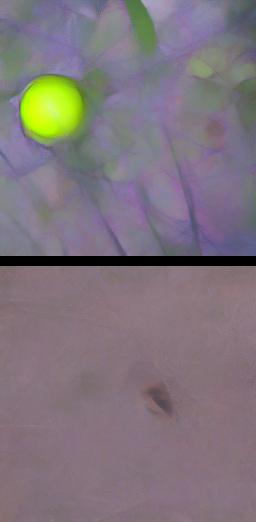

In [340]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdn, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="DSDN", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdn_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


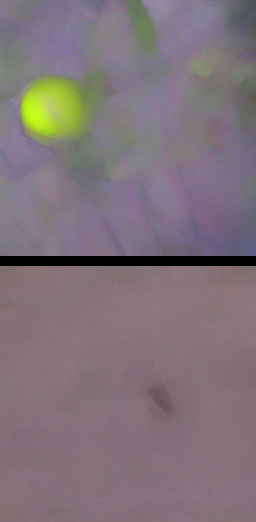

In [341]:
student, sampler_student, optimizer, scheduler = util.load_trained(tsd, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=False, model_type="TSD", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
tsd_img = new_image
new_image

# Final CIN Grid

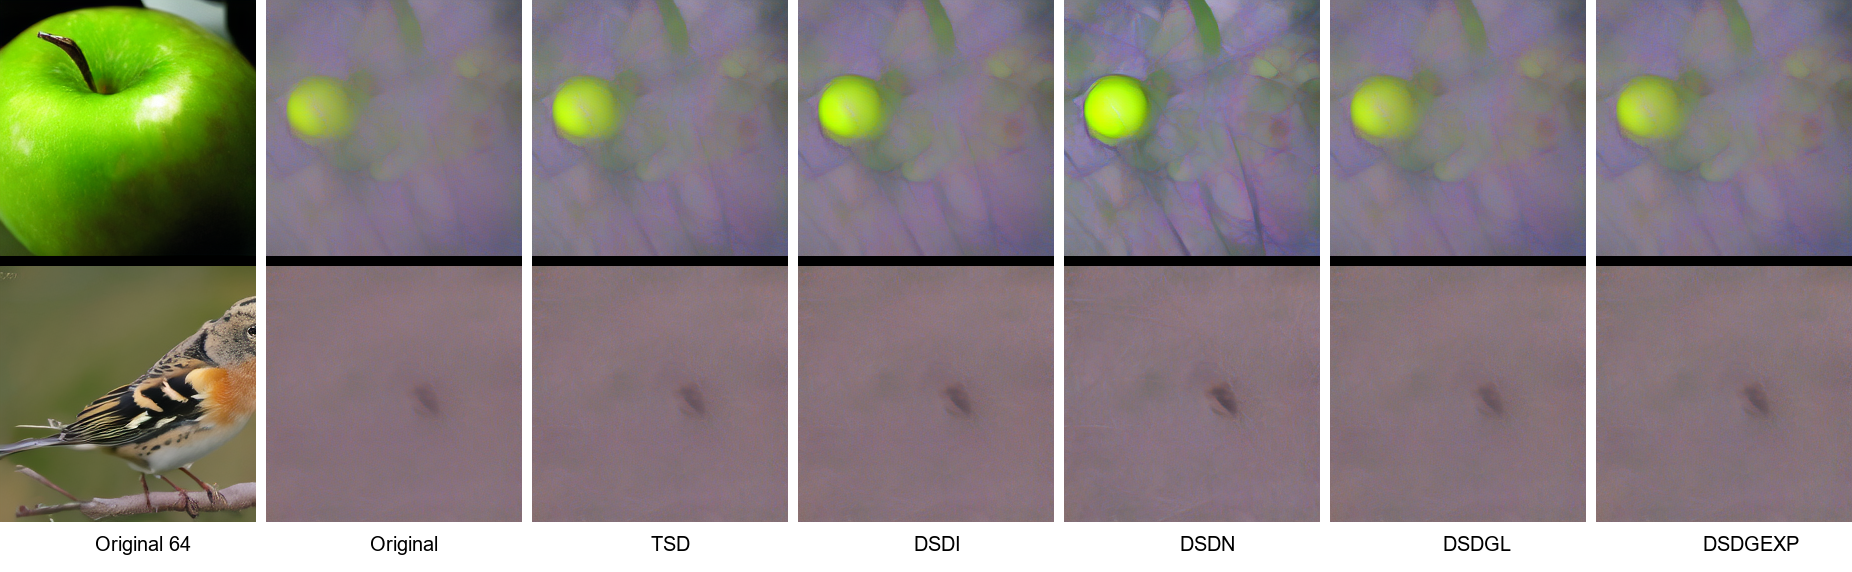

In [342]:
x_labels = ["Original 64", "Original", "TSD", "DSDI", "DSDN", "DSDGL", "DSDGEXP"]
grid = generate.create_horizontal_grid(original_64_img, original_img,tsd_img, dsdi_img, dsdn_img,  dsdgl_img, dsdgexp_img, celeb=False, steps=steps, font_size=20, x_labels=x_labels)
grid

# CELEB

In [343]:
import self_distillation
import saving_loading
import generate
import wandb
import util
import os
import torch

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb
os.environ['WANDB_NOTEBOOK_NAME'] = "Cin_256_custom.ipynb"


steps = 2
prompts=None
celeb = True

vertical = False


n = 2
if vertical:
    shape = (n, 1)
else:
    shape = (1, n)


# CELEB run:

In [344]:
config_path=f"{cwd}/models/configs/celebahq-ldm-vq-4.yaml"
original_path=f"{cwd}/models/CelebA.ckpt"



dsdi = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models\iterative\celeb_DSDI_64_1e-07_4000\\8.pt"
dsdgl = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models\gradual_linear\celeb_DSDGL_64_1e-07_4000\\2.pt"
dsdn = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_previous\\final_versions\celeb\DSDN\\32.pt"
dsdgexp = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_4000\gradual_exp\celeb_DSDGEXP_64_1e-07_4000\\2.pt"
tsd = f"{BASE}\Diffusion_Thesis\cin_256\data\\trained_models_previous\\final_versions\celeb\TSD\\2.pt"


## All versions

Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


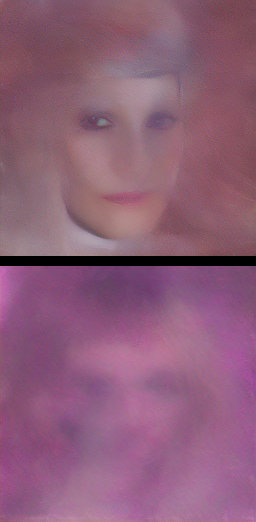

In [345]:
teacher, sampler_student = util.create_models(config_path, original_path, student=False)
new_image, noise_list, prompt_list = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="original", prompts=prompts)
del teacher, sampler_student
torch.cuda.empty_cache()
original_img = new_image
new_image

Loading model from c:\Diffusion_Thesis\cin_256/models/CelebA.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


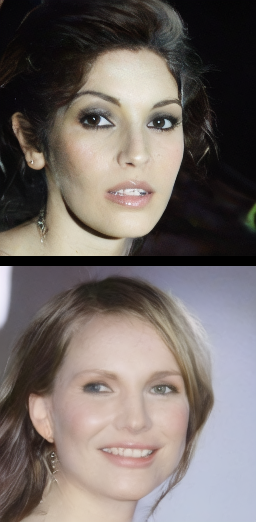

In [346]:
teacher, sampler_student = util.create_models(config_path, original_path, student=False)
new_image, noise_list, prompt_list = generate.ablation(sampler_student, steps=64, shape=shape, noise_list = noise_list, celeb=celeb, model_type="original", prompts=prompts)
del teacher, sampler_student
torch.cuda.empty_cache()
original_64_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


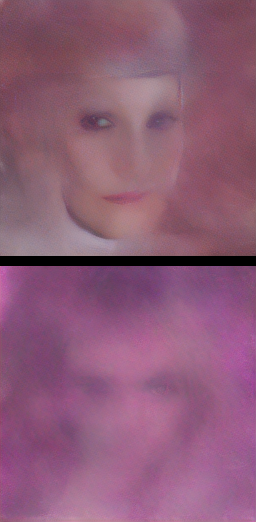

In [347]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdgexp, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="DSDGEXP", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdgexp_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


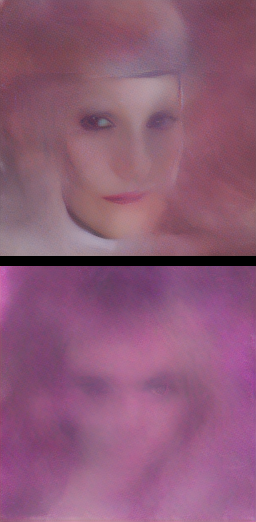

In [348]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdi, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="DSDI", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdi_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


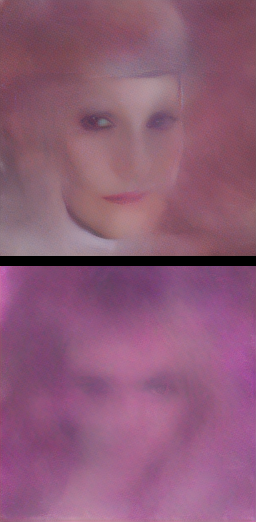

In [349]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdgl, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="DSDGL", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdgl_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


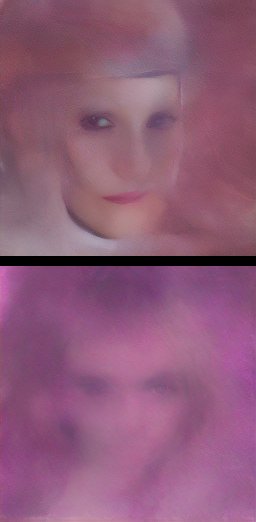

In [350]:
student, sampler_student, optimizer, scheduler = util.load_trained(dsdn, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="DSDN", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
dsdn_img = new_image
new_image

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/vq-f4/model.ckpt with 0 missing and 55 unexpected keys
Training LatentDiffusion as an unconditional model.


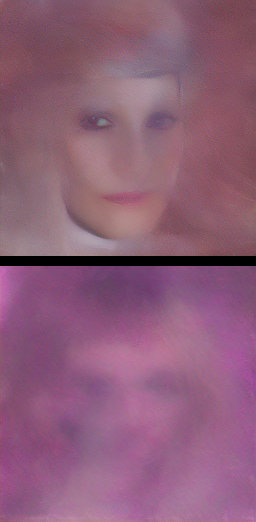

In [351]:
student, sampler_student, optimizer, scheduler = util.load_trained(tsd, config_path)
new_image, _, _ = generate.ablation(sampler_student, steps=steps, shape=shape, celeb=celeb, model_type="TSD", noise_list=noise_list, prompt_list=prompts)
del optimizer, scheduler, student, sampler_student
torch.cuda.empty_cache()
tsd_img = new_image
new_image

# Final CELEB Grid

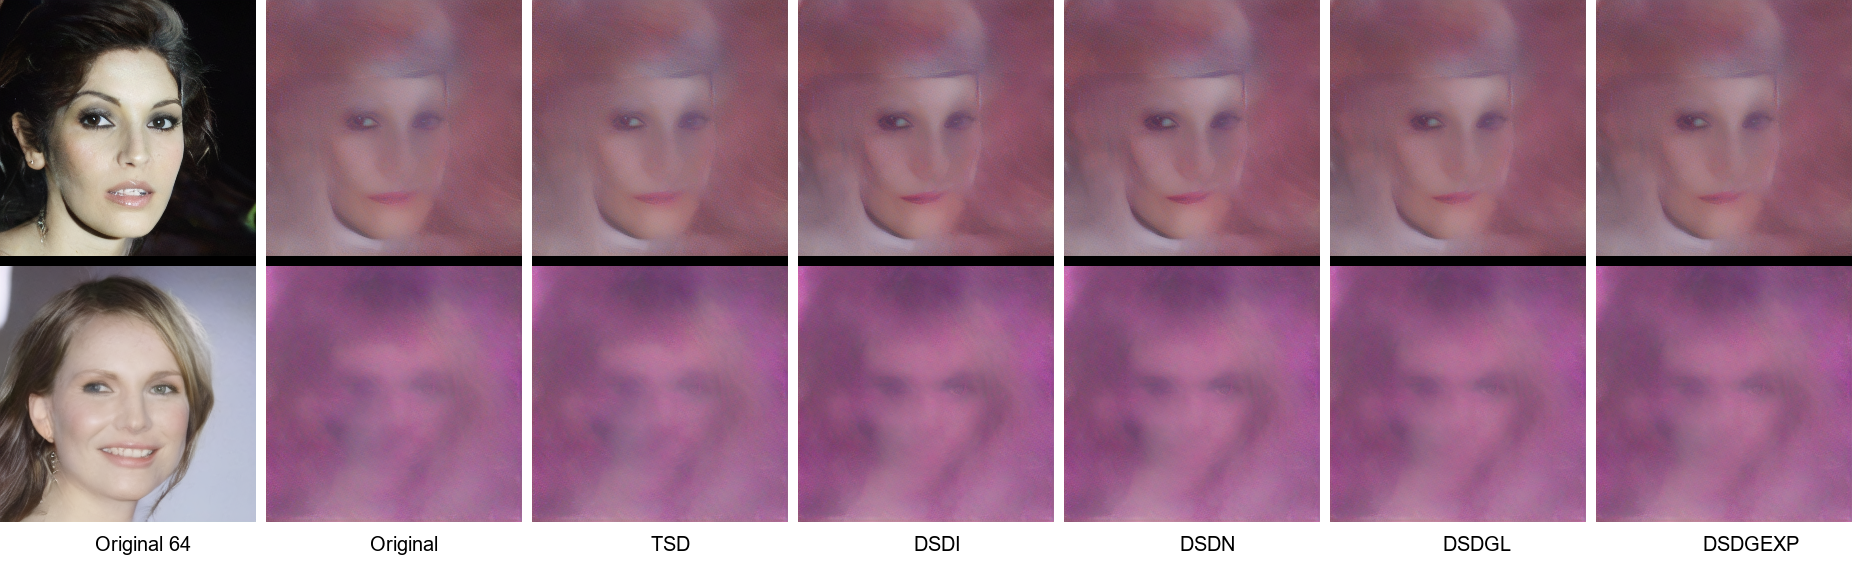

In [352]:
x_labels = ["Original 64", "Original", "TSD", "DSDI", "DSDN", "DSDGL", "DSDGEXP"]
# x_labels=None
grid = generate.create_horizontal_grid(original_64_img, original_img,tsd_img, dsdi_img, dsdn_img,  dsdgl_img, dsdgexp_img, celeb=celeb, steps=steps, x_labels=x_labels, font_size=20)
grid

In [353]:
# grid = generate.create_vertical_grid(original_64_img, original_img,tsd_img, dsdi_img, dsdn_img,  dsdgl_img, dsdgexp_img, celeb=celeb, steps=steps)
# grid